In [1]:
import pandas as pd  
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, MonthLocator, DayLocator
from matplotlib.dates import drange, DateLocator, DateFormatter
from matplotlib.dates import HourLocator, MinuteLocator, SecondLocator
from datetime import datetime
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

                                      ------------資料建置-----------

In [2]:
pw2014_ini=pd.read_csv('homeF_2014_merge_2.csv')
pw2015_ini=pd.read_csv('homeF_2015_merge_2.csv')

In [3]:
power = pd.concat([pw2014_ini,pw2015_ini],axis=0,ignore_index=True)

In [4]:
power.head()

,Date & Time,Usage [kW],Generation [kW],WaterHeater [kW],Solar [kW],Refrigerator [kW],Microwave [kW],Furnace [kW],WaterHeater3 [kW],WaterHeater2 [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 00:00:00,0.977402,0.009264,0.296840,0.009264,0.059256,0.002800,0.008474,0.000531,0.020002,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
1,2014-01-01 00:15:00,0.377746,0.009904,0.063231,0.009904,0.003734,0.002914,0.008633,0.000471,0.009642,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
2,2014-01-01 00:30:00,0.420196,0.010133,0.001511,0.010133,0.121228,0.002630,0.008059,0.000044,0.000011,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
3,2014-01-01 00:45:00,0.290328,0.010029,0.000058,0.010029,0.016986,0.002910,0.008511,0.000411,0.000202,...,10.0,Clear,8.33,1023.40,12.83,0.0,284.0,0.0,3.36,0.0
4,2014-01-01 01:00:00,0.307616,0.010038,0.000127,0.010038,0.014140,0.002691,0.008500,0.000400,0.000200,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0


In [67]:
#將標題儲存下來
cols=power.columns
cols

Index(['Date & Time', 'Usage [kW]', 'Generation [kW]', 'WaterHeater [kW]',
       'Solar [kW]', 'Refrigerator [kW]', 'Microwave [kW]', 'Furnace [kW]',
       'WaterHeater3 [kW]', 'WaterHeater2 [kW]', 'WaterHeater1 [kW]',
       'Master_Bdrm [kW]', 'Front_Bdrm [kW]', 'Kit_StoveWall [kW]',
       'Dishwasher_Disposal [kW]', 'Kit_SinkWall [kW]', 'Family_Rm [kW]',
       'Kit_Half-Bath_Foyer [kW]', 'Washing_Machine [kW]',
       'Guest_Bdrm_SmkDet [kW]', 'Dryer [kW]', 'Basement [kW]', 'Phase_B [kW]',
       'Phase_A [kW]', 'year', 'mon', 'day', 'hr', 'min', 'weekday',
       'is_holiday', 'time', 'temperature', 'icon', 'humidity', 'visibility',
       'summary', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability'],
      dtype='object')

In [6]:
#概況
target='Usage [kW]'
power[target].describe()

count    70080.000000
mean         1.315627
std          1.459243
min          0.000000
25%          0.438579
50%          0.815740
75%          1.284938
max         20.819441
Name: Usage [kW], dtype: float64

**接下來我計畫將前一個小時的各種data作為參數加入訓練集,
也想將後一個小時的部分加入,看看前後一個小時與各種天氣數據的關係,
因為是前後一個小時的data所以在"2014最初的一個小時的data將會沒有前一個小時的數據,
因此會將其drop掉。**

In [7]:
#先將Usage的數據儲存下來並且drop掉NaN,與最後一個小時的數據

empty = pd.DataFrame(columns=['Usage [kW]']) #造一個空的dataframe
X=power[['Usage [kW]']]
Past1=X.drop([35040,70073,70074,70075,70076,70077,70078,70079,70080,70081])
Next1=X.drop([0,1,2,3,4,5,6,7,35040,70081])
Past = pd.concat([empty,Past1],axis=0,ignore_index=True)
Next = pd.concat([empty,Next1],axis=0,ignore_index=True)
Past=Past.values
Next=Next.values


In [8]:
#drop掉最初一個小時的數據以及NaN

power_empty=pd.DataFrame(columns=cols)#造一個空的dataframe
power_t=power.drop([0,1,2,3,35040,70077,70078,70079,70080,70081 ])
power_= pd.concat([power_empty,power_t],axis=0,ignore_index=True)

In [9]:
#再將Past集合加入dataframe 就成為前一個小時的電量了
New_power=pd.concat([power_, pd.DataFrame(columns=list(['an_hour_Past_Usage [kW]','an_hour_Next_Usage [kW]']))])#將空的一個小時前欄位加入
New_power['an_hour_Past_Usage [kW]']=Past  #將資料加入上述欄位
New_power['an_hour_Next_Usage [kW]']=Next
#重新排序欄位
last_col = New_power.pop(New_power.columns[-1])
New_power.insert(2, last_col.name, last_col)
last_col = New_power.pop(New_power.columns[-1])
New_power.insert(3, last_col.name, last_col)
New_power.head()


,Date & Time,Usage [kW],an_hour_Next_Usage [kW],an_hour_Past_Usage [kW],Generation [kW],WaterHeater [kW],Solar [kW],Refrigerator [kW],Microwave [kW],Furnace [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 01:00:00,0.307616,0.378931,0.977402,0.010038,0.000127,0.010038,0.014140,0.002691,0.008500,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
1,2014-01-01 01:15:00,0.396122,0.301320,0.377746,0.010278,0.001511,0.010278,0.124819,0.002258,0.008111,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
2,2014-01-01 01:30:00,0.272560,0.280731,0.420196,0.010127,0.000118,0.010127,0.002522,0.002678,0.008587,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
3,2014-01-01 01:45:00,0.320803,0.456980,0.290328,0.010244,0.000298,0.010244,0.023630,0.002581,0.008497,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
4,2014-01-01 02:00:00,0.378931,0.448540,0.307616,0.010218,0.001389,0.010218,0.114904,0.002516,0.008121,...,10.0,Clear,8.99,1024.41,7.65,0.0,257.0,0.0,3.62,0.0


                                     -----------data exploration-----------

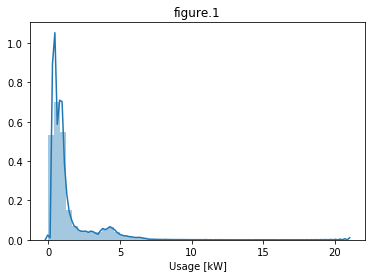

In [10]:
#查看電量大小分布圖
plt.title("figure.1")
sns.distplot(power[target]);


**由此圖可以發現, 大部分的Usage集中在0~2(kW)只有少部分的數據超過5(kW),**
**因此猜測最後近似線也會落在0~2(kW)這個區間內。**

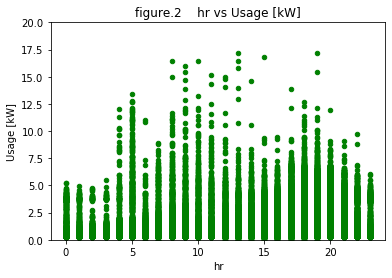

In [11]:
var = 'hr'
data = pd.concat([New_power[target], New_power[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,20),c = 'green');
plt.title("figure.2    hr vs Usage [kW]")
var = 'hr'

**這張圖無法反映出正確平均值,只能看出峰值大約落在哪裡,於是我決定再更進階一點。**

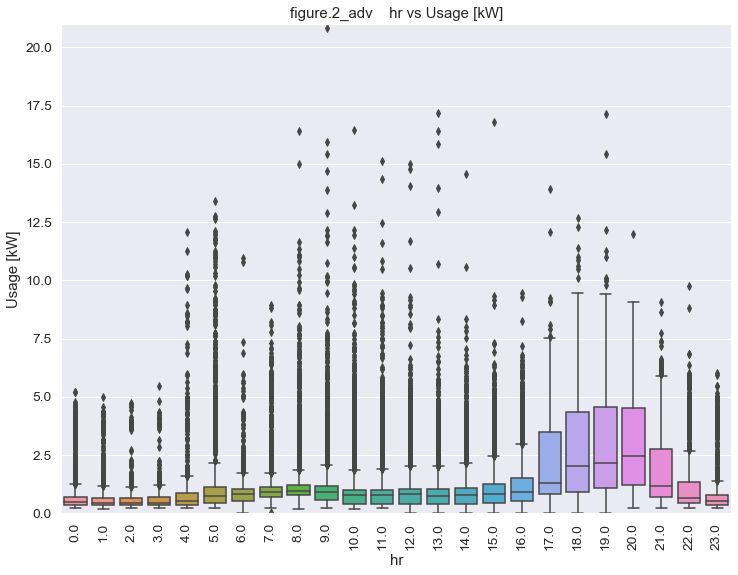

In [65]:
var = 'hr'
data = pd.concat([New_power[target], New_power[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 9))
fig = sns.boxplot(x=var, y=target, data=data)
fig.axis(ymin=0, ymax=21);
plt.title("figure.2_adv    hr vs Usage [kW]")
plt.xticks(rotation=90);

**由此圖可以發現17~21為用電量高峰期。**

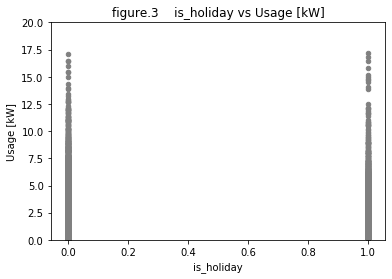

In [12]:
var = 'is_holiday'
data = pd.concat([New_power[target], New_power[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,20),c = 'grey');
plt.title("figure.3    is_holiday vs Usage [kW]")
var = 'is_holiday'

**由此圖可能還是看不出 到底假日用電量跟平日用電量的多寡,只能看出最大值相當,
因此決定各自篩選出來做平均。**

In [13]:
#假日平均用電量
fliter1 = (New_power["is_holiday"] == 1)
X=New_power[fliter1]#篩選出假日的data
x=X['Usage [kW]'].mean()

#平日平均用電量
fliter2 = (New_power["is_holiday"] == 0)
Y=New_power[fliter2]#篩選出假日的data
y=Y['Usage [kW]'].mean()

print('假日平均用電量 : ',x)
print('平日平均用電量 : ',y)

假日平均用電量 :  1.17770993946063
平日平均用電量 :  1.3706771030265223


**可以發現用電量平日較多,假日較少,
因此用電量與平日假日也有關。**

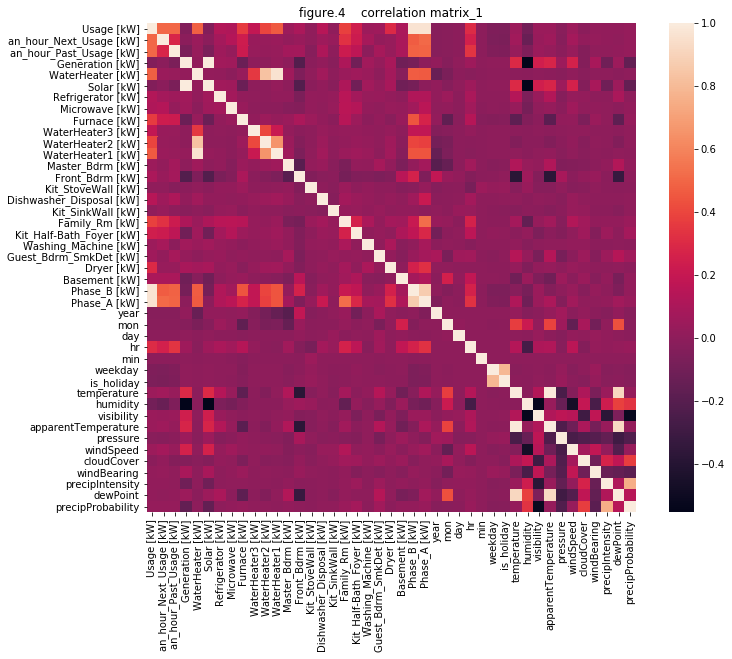

In [14]:
#correlation matrix
corrmat = New_power.corr()
f, ax = plt.subplots(figsize=(12, 9))
plt.title("figure.4    correlation matrix_1")
sns.heatmap(corrmat, vmax=1, square=True);


**此圖為下面那張圖的粗糙版,目的為大致觀察一下各點之間的相關度,
因為只要與電量相關的參數,皆無法提前得知,故不能拿來做預測,
將在下一個步驟簡化。**

In [15]:
New_power=New_power.drop([ 'Generation [kW]', 'WaterHeater [kW]',
       'Solar [kW]', 'Refrigerator [kW]', 'Microwave [kW]', 'Furnace [kW]',
       'WaterHeater3 [kW]', 'WaterHeater2 [kW]', 'WaterHeater1 [kW]',
       'Master_Bdrm [kW]', 'Front_Bdrm [kW]', 'Kit_StoveWall [kW]',
       'Dishwasher_Disposal [kW]', 'Kit_SinkWall [kW]', 'Family_Rm [kW]',
       'Kit_Half-Bath_Foyer [kW]', 'Washing_Machine [kW]',
       'Guest_Bdrm_SmkDet [kW]', 'Dryer [kW]', 'Basement [kW]', 'Phase_B [kW]',
       'Phase_A [kW]'], axis=1)

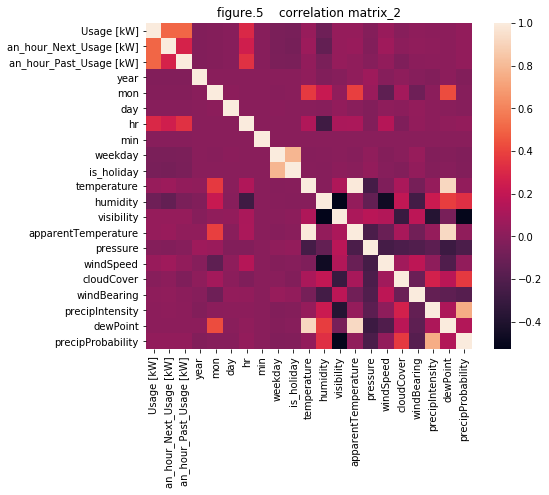

In [16]:
corrmat = New_power.corr()
f, ax = plt.subplots(figsize=(8, 6))
plt.title("figure.5    correlation matrix_2")
sns.heatmap(corrmat, vmax=1, square=True);


**第一階段簡化後的相關性圖示,但還是只能大致上看一下,
下一步驟進一步加強分析。**

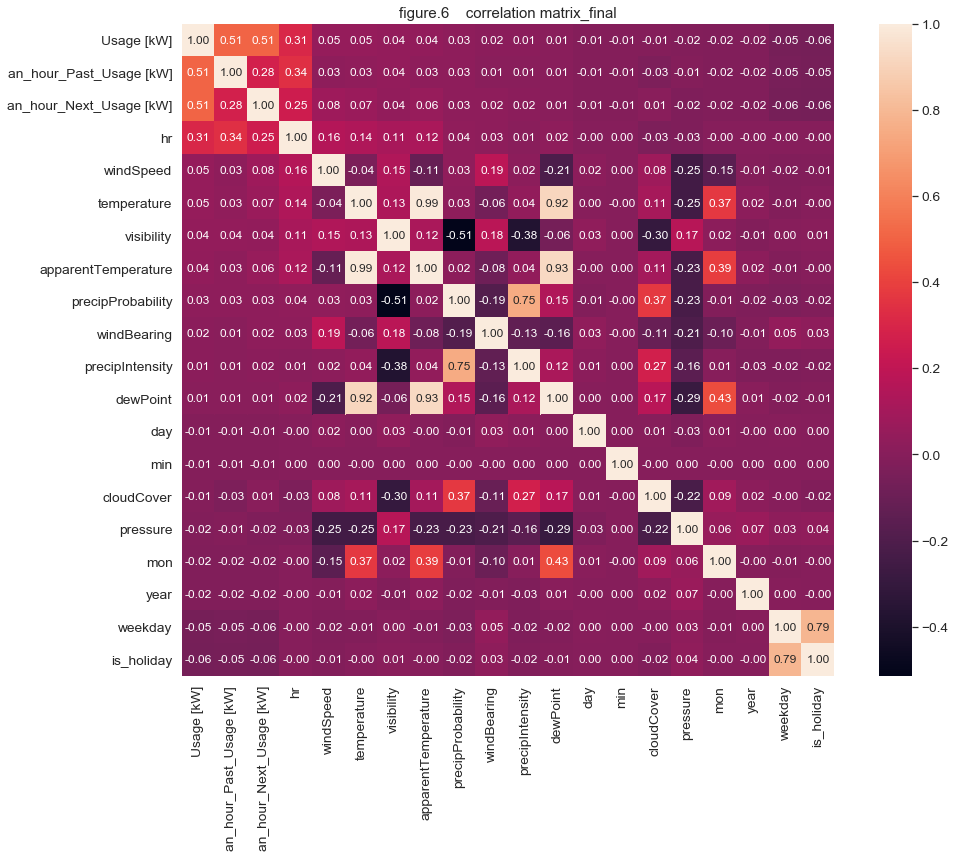

In [17]:
##Usage[kW] correlation matrix
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, target)[target].index
cm = New_power[cols].corr()
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(16,12 ))
hm = sns.heatmap(cm,vmax=1, cbar=True, annot=True, square=True,linewidths=0, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.title("figure.6    correlation matrix_final")
plt.show()


**此圖取出了以Usage為目標,與其相關度高的20名,
可以發現與Usage相關性最大的為hr這個參數,
因此待會將會把hr加入訓練集參數。**

**結論:
由an_hour_Next_Usage可以發現,
一個小時後的電量與"temperature,visibility,apparentTemperature,windSpeed"皆有關,
所以決定再把一個小時前的temperature,visibility,apparentTemperature,windSpeed抓來預測。**

                            ---------------根據分析結果修改資料建置-----------------

In [18]:
empty = pd.DataFrame(columns=['temperature','visibility','apparentTemperature','windSpeed']) #造一個空的dataframe
X=power[['temperature','visibility','apparentTemperature','windSpeed']]
Past1=X.drop([35040,70073,70074,70075,70076,70077,70078,70079,70080,70081])
Past = pd.concat([empty,Past1],axis=0,ignore_index=True)
Past_t=Past['temperature'].values
Past_v=Past['visibility'].values
Past_a=Past['apparentTemperature'].values
Past_w=Past['windSpeed'].values

In [19]:
#再將Past集合加入dataframe 就成為前一個小時的電量了
New_power=pd.concat([New_power, pd.DataFrame(columns=list(['Past_temperature','Past_visibility','Past_apparentTemperature','Past_windSpeed']))])#將空的一個小時前欄位加入

#將資料加入上述欄位
New_power['Past_temperature']=Past_t
New_power['Past_visibility']=Past_v
New_power['Past_apparentTemperature']=Past_a
New_power['Past_windSpeed']=Past_w

#重新排序欄位
for i in range(0,4):
     last_col = New_power.pop(New_power.columns[-1])
     New_power.insert(2, last_col.name, last_col)

New_power.head()

,Date & Time,Usage [kW],Past_temperature,Past_visibility,Past_apparentTemperature,Past_windSpeed,an_hour_Next_Usage [kW],an_hour_Past_Usage [kW],year,mon,...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 01:00:00,0.307616,20.85,10.0,8.33,12.83,0.378931,0.977402,2014.0,1.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
1,2014-01-01 01:15:00,0.396122,20.85,10.0,8.33,12.83,0.301320,0.377746,2014.0,1.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
2,2014-01-01 01:30:00,0.272560,20.85,10.0,8.33,12.83,0.280731,0.420196,2014.0,1.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
3,2014-01-01 01:45:00,0.320803,20.85,10.0,8.33,12.83,0.456980,0.290328,2014.0,1.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
4,2014-01-01 02:00:00,0.378931,19.72,10.0,8.49,10.03,0.448540,0.307616,2014.0,1.0,...,10.0,Clear,8.99,1024.41,7.65,0.0,257.0,0.0,3.62,0.0


**根據fig2我決定再加入一個feature is_Peak period 若為1代表hr在17~21之間,其他則為0**

In [77]:
Y=[]
X=New_power['hr'].values
for i in range(0, 70072): 
    if (X[i] >= 17)and(X[i] <=21) :
        Y.append(1)
    else :
        Y.append(0)
     

In [76]:
New_power=pd.concat([New_power, pd.DataFrame(columns=list(['is_Peak period']))])#將空的一個小時前欄位加入
New_power['is_Peak period']=Y
last_col = New_power.pop(New_power.columns[-1])
New_power.insert(2, last_col.name, last_col)
New_power.head()

,Date & Time,Usage [kW],is_Peak period,Past_temperature,Past_visibility,Past_apparentTemperature,Past_windSpeed,an_hour_Next_Usage [kW],an_hour_Past_Usage [kW],year,...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2014-01-01 01:00:00,0.307616,0,20.85,10.0,8.33,12.83,0.378931,0.977402,2014.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
1,2014-01-01 01:15:00,0.396122,0,20.85,10.0,8.33,12.83,0.301320,0.377746,2014.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
2,2014-01-01 01:30:00,0.272560,0,20.85,10.0,8.33,12.83,0.280731,0.420196,2014.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
3,2014-01-01 01:45:00,0.320803,0,20.85,10.0,8.33,12.83,0.456980,0.290328,2014.0,...,10.0,Clear,8.49,1023.36,10.03,0.0,285.0,0.0,2.94,0.0
4,2014-01-01 02:00:00,0.378931,0,19.72,10.0,8.49,10.03,0.448540,0.307616,2014.0,...,10.0,Clear,8.99,1024.41,7.65,0.0,257.0,0.0,3.62,0.0


**將is_Peak period成功加入Feature,接下來我想再看一次新加入的參數與Usage[kW]的關係**

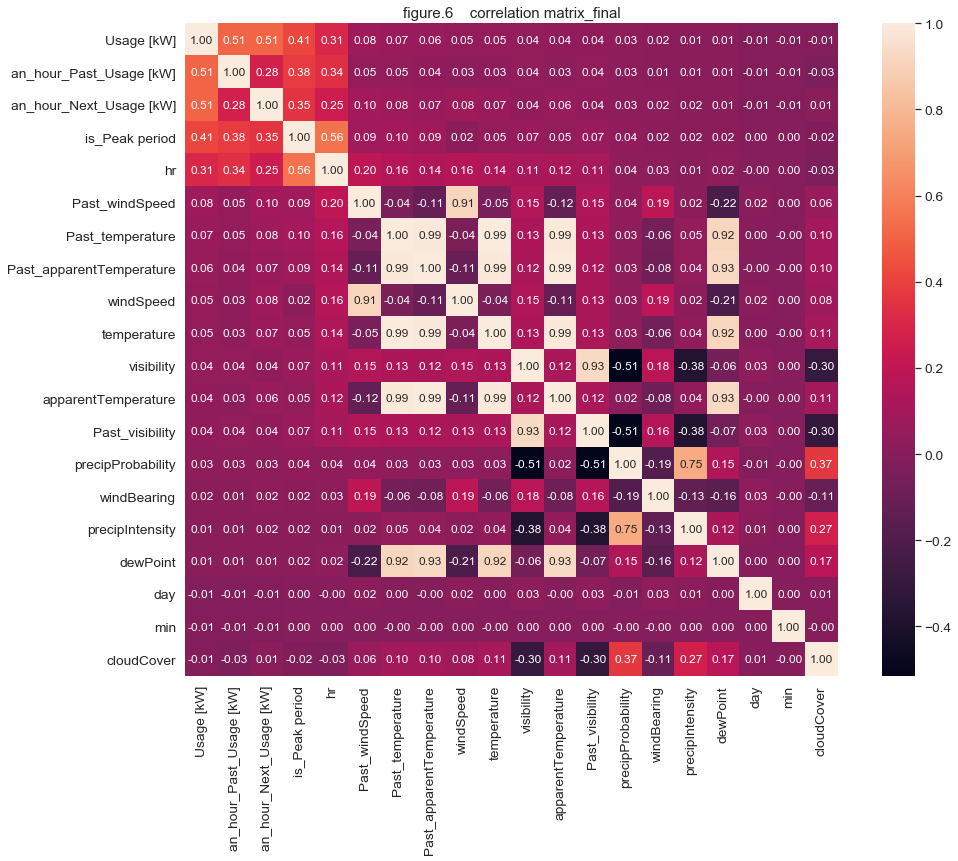

In [78]:
corrmat = New_power.corr()
##Usage[kW] correlation matrix
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, target)[target].index
cm = New_power[cols].corr()
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(16,12 ))
hm = sns.heatmap(cm,vmax=1, cbar=True, annot=True, square=True,linewidths=0, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.title("figure.6    correlation matrix_final")
plt.show()


**is_Peak period果不其然相關性與Usage[kW]很高,接下來也會將其納入預測中**

                                          -----------模型建構-----------

In [79]:
#將資料分成屬性及標籤
X = New_power[['time','an_hour_Past_Usage [kW]','is_Peak period','hr', 'is_holiday','Past_temperature','Past_visibility','Past_apparentTemperature']]
Y = New_power['Usage [kW]']

In [80]:
X1 = New_power[['Date & Time','time','is_Peak period','an_hour_Past_Usage [kW]','hr', 'is_holiday','Past_temperature','Past_visibility','Past_apparentTemperature']]
Y1 = New_power[['Date & Time','Usage [kW]']]
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.167,shuffle=False)


In [81]:
#建立訓練集和測試集

#2014年1月~2015年8月為訓練集,2015年9月~2015年12月為測試集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.167,shuffle=False)
#print('X_train: \n',X_train)
#print('X_test: \n',X_test)
#print('Y_train: \n',Y_train)
#print('Y_test: \n',Y_test)

In [82]:
#建立並訓練模型
regressor = LinearRegression()  
regressor.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

                                       -----------預測結果分析-----------

In [83]:
Y_pred=regressor.predict(X_test)
df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred})
df1 = df.head(25) #顯示實際值和預測值
df

,Actual,Predicted
58369,0.395950,0.776424
58370,0.398181,0.740252
58371,0.323748,0.794859
58372,0.415489,0.740130
58373,0.352773,0.770635
...,...,...
70067,1.899674,3.761523
70068,1.795777,2.634235
70069,1.843496,1.610717
70070,1.983620,1.336890


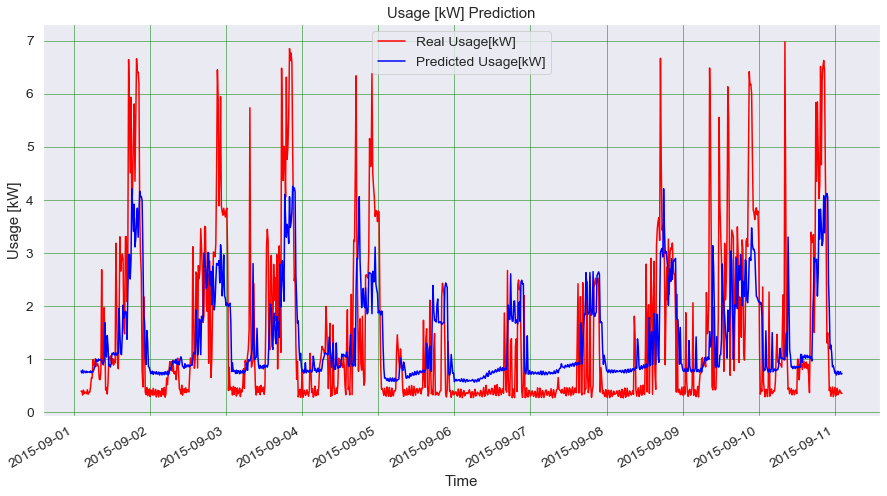

In [84]:
#測試集第一個data 2015-09-01 02:15:00
X_plt=New_power[New_power['Date & Time'].between('2015-09-01 02:15:00','2015-09-11 02:15:00')]
X_plt=X_plt['Date & Time']

xs = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in X_plt]


days=mdates.DayLocator()
hours = mdates.HourLocator()

dateFmt = mdates.DateFormatter('%Y-%m-%d')


# format the ticks
ax.xaxis.set_major_locator(days)  # 设置主要刻度
ax.xaxis.set_minor_locator(hours)  # 设置主要刻度
ax.xaxis.set_major_formatter(dateFmt)  # 刻度标志格式

Y_test_plt=Y_test.iloc[0:961]
Y_pred_plt=Y_pred[0:961]


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)    # 获得设置方法
ax.xaxis.set_major_locator(days)  # 设置主要刻度
ax.xaxis.set_minor_locator(hours)  # 设置主要刻度
ax.xaxis.set_major_formatter(dateFmt)  # 刻度标志格式

plt.plot(xs,Y_test_plt, color = 'red', label = 'Real Usage[kW]')  # 紅線表示Usage
plt.plot(xs,Y_pred_plt, color = 'blue', label = 'Predicted Usage[kW]')  # 藍線表示預測Usage
plt.title('Usage [kW] Prediction')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.xlabel('Time')
plt.ylabel('Usage [kW]')
plt.legend()
#fig.autofmt_xdate()  # 自动格式化显示方式
plt.gcf().autofmt_xdate() 
plt.show()



 
#視覺化


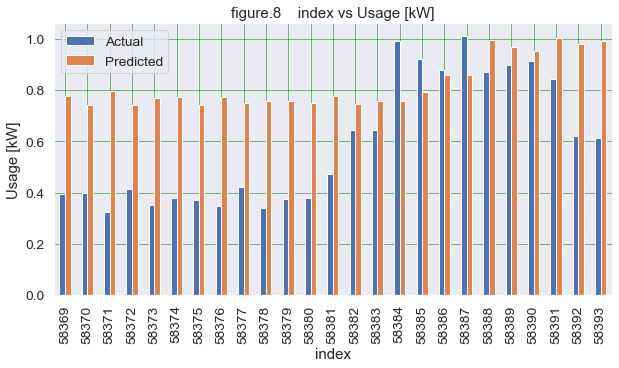

In [85]:
print(' ')
print('#視覺化')
df1.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('index')
plt.ylabel("Usage [kW]")
plt.title("figure.8    index vs Usage [kW]")
plt.show()

**由上面兩張圖,可以看到大致上的結果趨勢線,可以看到峰值的時候預測比較準確,
接下來我會針對峰值的部分放大分析。**

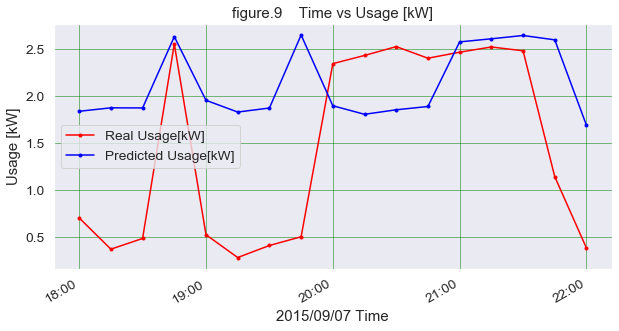

In [86]:
#取2015-09-7 18:00:00'到'2015-09-7 22:00:00的data

X_plt=New_power[New_power['Date & Time'].between('2015-09-07 18:00:00','2015-09-07 22:00:00')]
X_plt=X_plt['Date & Time']

xs = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in X_plt]

dateFmt = mdates.DateFormatter('%H:%M')

hours = mdates.HourLocator()
minutes = mdates.MinuteLocator()

Y_test_plt=Y_test.iloc[639:656]
Y_pred_plt=Y_pred[639:656]

# format the ticks
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)    # 获得设置方法
ax.xaxis.set_major_locator(hours)  # 设置主要刻度
ax.xaxis.set_minor_locator(minutes)  # 设置主要刻度
ax.xaxis.set_major_formatter(dateFmt)  # 刻度标志格式

plt.plot(xs,Y_test_plt,'-', marker='.', color = 'red', label = 'Real Usage[kW]')  # 紅線表示Usage
plt.plot(xs,Y_pred_plt,'-', marker='.', color = 'blue', label = 'Predicted Usage[kW]')  # 藍線表示預測Usage
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.xlabel('2015/09/07 Time')
plt.ylabel("Usage [kW]")
plt.title("figure.9    Time vs Usage [kW]")
plt.legend()
plt.gcf().autofmt_xdate() 
plt.show()


In [87]:
Y_test

58369    0.395950
58370    0.398181
58371    0.323748
58372    0.415489
58373    0.352773
           ...   
70067    1.899674
70068    1.795777
70069    1.843496
70070    1.983620
70071    1.436781
Name: Usage [kW], Length: 11703, dtype: float64

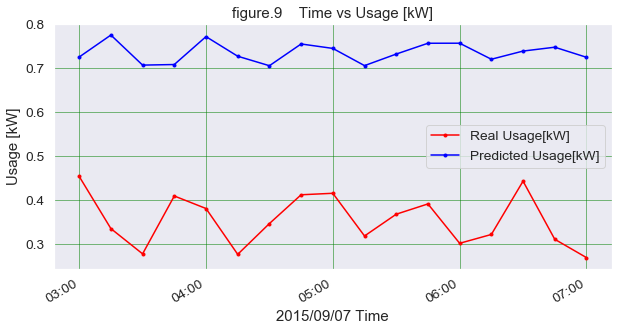

In [88]:
#取2015-09-7 3:00:00'到'2015-09-7 7:00:00的data

X_plt=New_power[New_power['Date & Time'].between('2015-09-07 03:00:00','2015-09-07 07:00:00')]
X_plt=X_plt['Date & Time']

xs = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in X_plt]

dateFmt = mdates.DateFormatter('%H:%M')

hours = mdates.HourLocator()
minutes = mdates.MinuteLocator()

Y_test_plt=Y_test.iloc[579:596]
Y_pred_plt=Y_pred[579:596]


# format the ticks
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)    # 获得设置方法
ax.xaxis.set_major_locator(hours)  # 设置主要刻度
ax.xaxis.set_minor_locator(minutes)  # 设置主要刻度
ax.xaxis.set_major_formatter(dateFmt)  # 刻度标志格式

plt.plot(xs,Y_test_plt,'-', marker='.', color = 'red', label = 'Real Usage[kW]')  # 紅線表示Usage
plt.plot(xs,Y_pred_plt,'-', marker='.', color = 'blue', label = 'Predicted Usage[kW]')  # 藍線表示預測Usage
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.xlabel('2015/09/07 Time')
plt.ylabel("Usage [kW]")
plt.title("figure.9    Time vs Usage [kW]")
plt.legend()
plt.gcf().autofmt_xdate() 
plt.show()




**由上面兩個圖比較可以看到確實在峰值時預測成功率較高,主要是演算法在像峰值這種特殊的值的時候,會更好辨識與學習,使得其很好辨識甚麼時候會到達峰值,並且有加入is_Peak period,因此預測成功率會較高。**

In [89]:
#平均絕對誤差(MAE)、均方誤差(MSE)、均方根誤差(RMSE)
print('*Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
print(' ')  
print('檢查準確度: ',regressor.score(X_train, Y_train))

*Mean Absolute Error: 0.6219131002966021
Mean Squared Error: 0.9383337635180822
Root Mean Squared Error: 0.9686762944957836
 
檢查準確度:  0.30178937053593924


**接下來我想比較看看若直接把前一個小時的電量,拿來當成預測結果,那麼MAE會是多少呢**

In [90]:
#直接將前一小時的電量拿來當成預測結果之MAE
print('*Mean Absolute Error:', metrics.mean_absolute_error(New_power['Usage [kW]'],New_power['an_hour_Next_Usage [kW]']))  

*Mean Absolute Error: 0.7170145320543154


**就分析結果來說,還有很大的進步空間,未來可以嘗試用2個小時以前或是3個小時以前的數據來進行預測,
來增加預測成功率以及MAE。**

                                        -----------未來預測-----------

In [92]:
#假設為2015年12月31號22:45分的下一個小時=2015年12月31號23:45分溫度為20度
data = {'time':[1451619900],'is_Peak period':[0],'an_hour_Past_Usage [kW]':[1.899674],'hr':[23],
       'is_holiday':[0],'Past_temperature':[37.30],'Past_visibility':[10],'Past_apparentTemperature':[29.58]}
next_hours_data = pd.DataFrame(data)
next_hours_data



,time,is_Peak period,an_hour_Past_Usage [kW],hr,is_holiday,Past_temperature,Past_visibility,Past_apparentTemperature
0,1451619900,0,1.899674,23,0,37.3,10,29.58


In [93]:
#預測下一個小時用電量
next_hours=regressor.predict(next_hours_data)
print('下一小時的電量: ',next_hours)


下一小時的電量:  [2.4694194]


In [ ]:
#假設用一個小時之前的time,Usage [kW],temperature,visibility,apparentTemperature以及hr,holiday的dataset,
#此dataset之輸出結果為我們的目標

pw2016=pd.read_csv('xxx')#xxx為檔案路徑名稱

In [ ]:
#以時間,溫度,小時為特徵來預測用電量
Z = power2016[['time','is_Peak period':[0],'an_hour_Past_Usage [kW]','hr', 'is_holiday','Past_temperature','Past_visibility','Past_apparentTemperature']]
Z_pred=regressor.predict(Z)#預測結果
df = pd.DataFrame({ 'Predicted': Z_pred})
df1 = df.head(25) 
df